<a href="https://colab.research.google.com/github/babak-tafreshi/AER850_Project2/blob/main/Project2_AER850.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# AER 850 Project 2
# Babak Nassir Tafreshi

In [3]:
# Setting up the environment


import os, pathlib, json, math, random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("TensorFlow:", tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)


TensorFlow: 2.19.0
GPU available: True


# Step 1: Data Processing
Data processing is the first step to perform any type of image classification task. There are a few steps involved with this step.

• The first is to define the input image shape which is required to be (500,500, 3) which is the desired width, height and channel of the image for model training.

• Establish the train and validation data directory (use relative paths). The data is split into 3 folders - Train, Validation and Test which contain 1942, 431 and 539 images respectively.

• Perform data augmentation such as re-scaling, shear range and zoom range by using packages such as Keras’ image preprocessing pipeline, or torchvision transforms for the train data and validation data (only apply re-scaling for validation).

• Create the train and validation generator using Keras’s built-in imagedatasetfromdirectory function which takes in the data directory, image target size, batch size (32), and class mode (categorical) or by using PyTorch’s Dataloader.

In [4]:
IMG_SIZE = (500, 500)   # width, height
IMG_CHANNELS = 3        # RGB
BATCH_SIZE = 32
SEED = 42

# Paths (These are uploaded into my drive, so you might have to change these)
TRAIN_DIR = pathlib.Path("/content/drive/MyDrive/AER 850/Project 2/train")
VAL_DIR   = pathlib.Path("/content/drive/MyDrive/AER 850/Project 2/valid")
TEST_DIR  = pathlib.Path("/content/drive/MyDrive/AER 850/Project 2/test")

for p in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    print(p, "-> OK" if p.exists() else "MISSING")


/content/drive/MyDrive/AER 850/Project 2/train -> OK
/content/drive/MyDrive/AER 850/Project 2/valid -> OK
/content/drive/MyDrive/AER 850/Project 2/test -> OK


In [5]:
# Count images - a quick sanity check
VALID_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tif", ".tiff"}

def count_images(folder: pathlib.Path):
    total = 0
    per_class = {}
    if not folder.exists():
        return total, per_class
    for cls_dir in sorted([d for d in folder.iterdir() if d.is_dir()]):
        n = sum(1 for f in cls_dir.rglob("*") if f.suffix.lower() in VALID_EXTS)
        per_class[cls_dir.name] = n
        total += n
    return total, per_class

for name, path in [("Train", TRAIN_DIR), ("Validation", VAL_DIR), ("Test", TEST_DIR)]:
    total, per_class = count_images(path)
    print(f"{name}: {total} images ->", per_class)

expected = {"Train": 1942, "Validation": 431, "Test": 539}
actual = {name: count_images(path)[0] for name, path in [("Train", TRAIN_DIR), ("Validation", VAL_DIR), ("Test", TEST_DIR)]}
print("Expected:", expected)
print("Actual:  ", actual)


Train: 1942 images -> {'crack': 676, 'missing-head': 661, 'paint-off': 605}
Validation: 431 images -> {'crack': 175, 'missing-head': 169, 'paint-off': 87}
Test: 539 images -> {'crack': 211, 'missing-head': 200, 'paint-off': 128}
Expected: {'Train': 1942, 'Validation': 431, 'Test': 539}
Actual:   {'Train': 1942, 'Validation': 431, 'Test': 539}


## ImageDataGenerator pipelines

In [6]:
# --- Data augmentation & rescaling ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.15,
    zoom_range=0.15,
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [7]:
# --- Generators from directory ---
train_gen = train_datagen.flow_from_directory(
    directory=str(TRAIN_DIR),
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

val_gen = val_datagen.flow_from_directory(
    directory=str(VAL_DIR),
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

test_gen = test_datagen.flow_from_directory(
    directory=str(TEST_DIR),
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False  # keep False for stable evaluation later
)

print("Class indices:", train_gen.class_indices)
with open("class_indices.json", "w") as f:
    json.dump(train_gen.class_indices, f, indent=2)


Found 1942 images belonging to 3 classes.
Found 431 images belonging to 3 classes.
Found 539 images belonging to 3 classes.
Class indices: {'crack': 0, 'missing-head': 1, 'paint-off': 2}


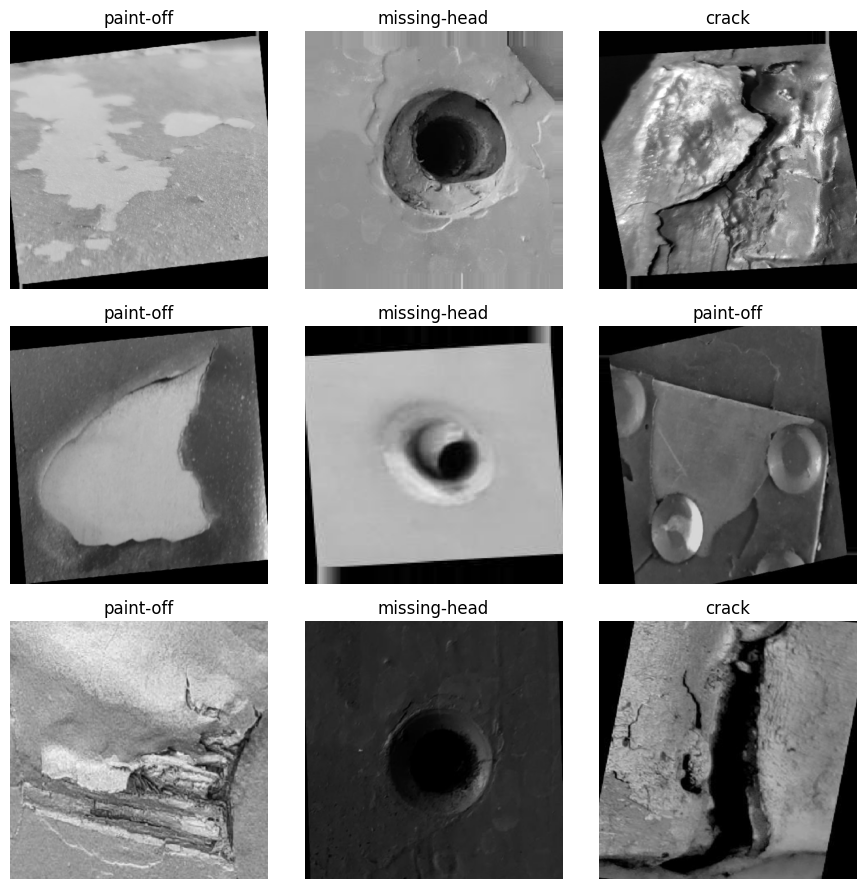

In [8]:
# --- Peek at a small augmented batch ---
import matplotlib.pyplot as plt

def show_batch(generator, n=9):
    imgs, labels = next(generator)
    class_names = {v:k for k,v in generator.class_indices.items()}
    cols = int(math.sqrt(n))
    rows = int(math.ceil(n / cols))
    plt.figure(figsize=(cols*3, rows*3))
    for i in range(min(n, len(imgs))):
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i])
        lbl = class_names[int(np.argmax(labels[i]))]
        plt.title(lbl)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_batch(train_gen, n=9)


# Step 2: Neural Network Architecture Design
For this stage you are required to build your own custom neural network. You are allowed to use any machine learning platform. If you are using Tensorflow or PyTorch, you can start with the following tutorials: Tensorflow CNN Tutorial or Pytorch CNN Tutorial. The neural network will have multiple layers. The layers to extract the features from the given images are outlined below.

• Convolutional layers which are accessed through the Conv2D package which filters the images and extract key features. The three main components to explore within this layer are: number of filters, kernel size, and stride. (The main focus can be on filters and kernel size).

• The next layer is the MaxPooling2D layer which follows the convolutional layers and pools the extracted features and takes the highest value.

• The Flatten layer is then utilized after all the convolutions and max pooling layers, which is applied before the dense layers.

• Lastly, the fully connected Dense and Dropout layers are utilized perform the final predictions. (The final dense should only have 3 neurons, correlating to the label classes).

• Note: You can adjust the convolutional and fully connected layers to improve the performance of the network.

In [9]:
# --- Step 2: Architecture Design (Keras/TensorFlow) ---
from tensorflow.keras import models, layers, optimizers, regularizers

# Input image spec from Step 1 (width, height, channels) = (500, 500, 3)
INPUT_SHAPE = (500, 500, 3)
NUM_CLASSES = 3  # crack, missing-heads, paint-off


In [10]:
def build_model_a_baseline(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    """
    Model A (Baseline, rubric-aligned):
    - Focus on exploring 'filters' and 'kernel_size' in Conv2D layers.
    - Each conv block is followed by MaxPooling2D to downsample.
    - Uses Flatten (explicitly required) before Dense classifier.
    - Includes Dropout for regularization.
    """
    inputs = layers.Input(shape=input_shape)

    # ----- Block 1 -----
    # Conv layer extracts low-level patterns (edges, small textures).
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1),
                      padding="same", activation="relu",
                      kernel_initializer="he_normal")(inputs)
    # A second conv in the block increases representational power.
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1),
                      padding="same", activation="relu",
                      kernel_initializer="he_normal")(x)
    # MaxPooling keeps the strongest activations while halving spatial size.
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)  # 500 -> 250

    # ----- Block 2 -----
    # Increase filters to learn more complex features.
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1),
                      padding="same", activation="relu",
                      kernel_initializer="he_normal")(x)
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1),
                      padding="same", activation="relu",
                      kernel_initializer="he_normal")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)  # 250 -> 125

    # ----- Block 3 -----
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1),
                      padding="same", activation="relu",
                      kernel_initializer="he_normal")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)  # 125 -> ~62

    # ----- Flatten before Dense classifier (as required) -----
    x = layers.Flatten()(x)

    # ----- Fully-connected head -----
    # Dense layer mixes features from all locations; Dropout reduces overfitting.
    x = layers.Dense(256, activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Dropout(0.5)(x)

    # Final classification layer: 3 neurons for 3 classes + softmax probabilities.
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="ModelA_Baseline_CNN")
    return model

model_a = build_model_a_baseline()
model_a.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),  # will tune in Step 3
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Print a readable summary for your report
model_a.summary(line_length=120)


Model: "ModelA_Baseline_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)                            │ (None, 500, 500, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv2d (Conv2D)                                     │ (None, 500, 500, 32)                   │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv2d_1 (Conv2D)                                   │ (None, 500, 500, 32)                   │                 9,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ max_pooling2d (MaxPooling2D)                        │ (None, 250, 250, 32)                   │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv2d_2 (Conv2D)                                   │ (None, 250, 250, 64)                   │                18,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv2d_3 (Conv2D)                                   │ (None, 250, 250, 64)                   │                36,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ max_pooling2d_1 (MaxPooling2D)                      │ (None, 125, 125, 64)                   │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv2d_4 (Conv2D)                                   │ (None, 125, 125, 128)                  │                73,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ max_pooling2d_2 (MaxPooling2D)                      │ (None, 62, 62, 128)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ flatten (Flatten)                                   │ (None, 492032)                         │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense (Dense)                                       │ (None, 256)                            │           125,960,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dropout (Dropout)                                   │ (None, 256)                            │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense_1 (Dense)                                     │ (None, 3)                              │                   
└─────────────────────────────────────────────────────┴────────────────────────────────────────┴───────────────────

 Total params: 126,100,643 (481.04 MB)

 Trainable params: 126,100,643 (481.04 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
def build_model_b_enhanced(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    """
    Model B (Enhanced, still rubric-compliant):
    - Explores filter sizes and kernel sizes more aggressively.
    - Uses a larger first kernel (5x5) to capture broader structures (e.g., long cracks).
    - Adds an extra conv in deeper blocks for richer features.
    - Keeps Flatten before Dense (to strictly follow the spec).
    - Adds mild L2 regularization to conv kernels to reduce overfitting.
    """
    l2w = 1e-4  # mild L2 weight decay on convs

    inputs = layers.Input(shape=input_shape)

    # ----- Block 1 (broader receptive field to start) -----
    x = layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1),
                      padding="same", activation="relu",
                      kernel_initializer="he_normal",
                      kernel_regularizer=regularizers.l2(l2w))(inputs)
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1),
                      padding="same", activation="relu",
                      kernel_initializer="he_normal",
                      kernel_regularizer=regularizers.l2(l2w))(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)  # 500 -> 250

    # ----- Block 2 -----
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1),
                      padding="same", activation="relu",
                      kernel_initializer="he_normal",
                      kernel_regularizer=regularizers.l2(l2w))(x)
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1),
                      padding="same", activation="relu",
                      kernel_initializer="he_normal",
                      kernel_regularizer=regularizers.l2(l2w))(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)  # 250 -> 125

    # ----- Block 3 (deeper features) -----
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1),
                      padding="same", activation="relu",
                      kernel_initializer="he_normal",
                      kernel_regularizer=regularizers.l2(l2w))(x)
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1),
                      padding="same", activation="relu",
                      kernel_initializer="he_normal",
                      kernel_regularizer=regularizers.l2(l2w))(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)  # 125 -> ~62

    # ----- Flatten + classifier -----
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="ModelB_Enhanced_CNN")
    return model

model_b = build_model_b_enhanced()
model_b.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),  # will tune in Step 3
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_b.summary(line_length=120)


Model: "ModelB_Enhanced_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ input_layer_1 (InputLayer)                          │ (None, 500, 500, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv2d_5 (Conv2D)                                   │ (None, 500, 500, 32)                   │                 2,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv2d_6 (Conv2D)                                   │ (None, 500, 500, 32)                   │                 9,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ max_pooling2d_3 (MaxPooling2D)                      │ (None, 250, 250, 32)                   │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv2d_7 (Conv2D)                                   │ (None, 250, 250, 64)                   │                18,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv2d_8 (Conv2D)                                   │ (None, 250, 250, 64)                   │                36,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ max_pooling2d_4 (MaxPooling2D)                      │ (None, 125, 125, 64)                   │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv2d_9 (Conv2D)                                   │ (None, 125, 125, 128)                  │                73,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv2d_10 (Conv2D)                                  │ (None, 125, 125, 128)                  │               147,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ max_pooling2d_5 (MaxPooling2D)                      │ (None, 62, 62, 128)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ flatten_1 (Flatten)                                 │ (None, 492032)                         │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense_2 (Dense)                                     │ (None, 256)                            │           125,960,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dropout_1 (Dropout)                                 │ (None, 256)                            │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense_3 (Dense)                                     │ (None, 3)                              │                   
└─────────────────────────────────────────────────────┴────────────────────────────────────────┴───────────────────

 Total params: 126,249,763 (481.60 MB)

 Trainable params: 126,249,763 (481.60 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Choose the model you want to train in Step 3
current_model = model_b  # or model_a
print("Selected model:", current_model.name)


Selected model: ModelB_Enhanced_CNN


# STEP 3

In [13]:
# =========================
# STEP 3 • Setup & Generators
# (Safe to run even if you already ran Step 1)
# =========================

import os, math, json, pathlib, time, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

# ---- Reproducibility (still stochastic due to augmentations/GPU) ----
SEED = 42
tf.keras.utils.set_random_seed(SEED)

# ---- Input spec required by the assignment ----
IMG_SIZE   = (500, 500)      # (width, height)
IMG_SHAPE  = (500, 500, 3)   # (w, h, c)
BATCH_SIZE = 32
NUM_CLASSES = 3

# ---- EDIT THESE PATHS IF YOUR DATA IS ELSEWHERE ----
# Expected folder structure:
# ./data/Train/{crack, missing-heads, paint-off}
# ./data/Validation/{crack, missing-heads, paint-off}
# ./data/Test/{crack, missing-heads, paint-off}
TRAIN_DIR = pathlib.Path("/content/drive/MyDrive/AER 850/Project 2/train")
VAL_DIR   = pathlib.Path("/content/drive/MyDrive/AER 850/Project 2/valid")
TEST_DIR  = pathlib.Path("/content/drive/MyDrive/AER 850/Project 2/test")

# ---- Check paths exist (helpful message instead of cryptic errors) ----
for p in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    print(f"{p} -> {'OK' if p.exists() else 'MISSING'}")
if not (TRAIN_DIR.exists() and VAL_DIR.exists() and TEST_DIR.exists()):
    raise SystemExit("❌ Dataset folders not found. Please update TRAIN_DIR/VAL_DIR/TEST_DIR above.")

# ---- Generators (Train has augmentation; Val/Test only rescale) ----
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.15,
    zoom_range=0.15
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    directory=str(TRAIN_DIR),
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)
val_gen = val_datagen.flow_from_directory(
    directory=str(VAL_DIR),
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)
test_gen = test_datagen.flow_from_directory(
    directory=str(TEST_DIR),
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# ---- Steps per epoch for the fit() call ----
train_steps = math.ceil(train_gen.samples / train_gen.batch_size)
val_steps   = math.ceil(val_gen.samples   / val_gen.batch_size)

print(f"Train steps/epoch: {train_steps}, Val steps/epoch: {val_steps}")
print("Class indices:", train_gen.class_indices)

# Save mapping for later reports (confusion matrix labels, etc.)
with open("class_indices.json", "w") as f:
    json.dump(train_gen.class_indices, f, indent=2)


/content/drive/MyDrive/AER 850/Project 2/train -> OK
/content/drive/MyDrive/AER 850/Project 2/valid -> OK
/content/drive/MyDrive/AER 850/Project 2/test -> OK
Found 1942 images belonging to 3 classes.
Found 431 images belonging to 3 classes.
Found 539 images belonging to 3 classes.
Train steps/epoch: 61, Val steps/epoch: 14
Class indices: {'crack': 0, 'missing-head': 1, 'paint-off': 2}


In [14]:
# =========================
# Activation helper
# =========================
from tensorflow.keras.layers import LeakyReLU

def add_activation(x, act_name: str):
    """
    Adds the requested activation layer to tensor x.
    Supports: 'relu', 'leakyrelu', 'elu'
    """
    act = act_name.lower()
    if act == "relu":
        return layers.Activation("relu")(x)
    elif act == "leakyrelu":
        return LeakyReLU(alpha=0.1)(x)
    elif act == "elu":
        return layers.ELU(alpha=1.0)(x)
    else:
        raise ValueError(f"Unknown activation: {act_name}")


In [15]:
# =========================
# Parametric CNN builder (Rubric-compliant)
# =========================
def build_cnn_model(
    input_shape=IMG_SHAPE,
    num_classes=NUM_CLASSES,
    conv_activation="relu",   # 'relu' | 'leakyrelu' | 'elu'
    dense_activation="relu",  # 'relu' | 'elu'
    base_filters=32,          # 32, 64 (filters grow per block)
    dense_units=256,          # 128, 256, 512
    l2w=0.0,                  # 0.0, 1e-4
    dropout_rate=0.5          # 0.3, 0.5
):
    """
    Architecture:
      [Conv(3x3) + Act] x2 -> MaxPool
      [Conv(3x3) + Act] x2 -> MaxPool
      [Conv(3x3) + Act]    -> MaxPool
      Flatten -> Dense(dense_units) + Act -> Dropout -> Dense(3, Softmax)
    - Focus points to tune: filters (base_filters) and activations.
    - Keeps Flatten before Dense (explicit requirement).
    """
    reg = regularizers.l2(l2w) if l2w > 0 else None
    inputs = layers.Input(shape=input_shape)

    # Block 1 (two convs)
    x = layers.Conv2D(base_filters, (3,3), padding="same",
                      kernel_initializer="he_normal", kernel_regularizer=reg)(inputs)
    x = add_activation(x, conv_activation)
    x = layers.Conv2D(base_filters, (3,3), padding="same",
                      kernel_initializer="he_normal", kernel_regularizer=reg)(x)
    x = add_activation(x, conv_activation)
    x = layers.MaxPooling2D((2,2))(x)  # 500 -> 250

    # Block 2 (two convs, double filters)
    x = layers.Conv2D(base_filters*2, (3,3), padding="same",
                      kernel_initializer="he_normal", kernel_regularizer=reg)(x)
    x = add_activation(x, conv_activation)
    x = layers.Conv2D(base_filters*2, (3,3), padding="same",
                      kernel_initializer="he_normal", kernel_regularizer=reg)(x)
    x = add_activation(x, conv_activation)
    x = layers.MaxPooling2D((2,2))(x)  # 250 -> 125

    # Block 3 (one conv, quadruple base filters)
    x = layers.Conv2D(base_filters*4, (3,3), padding="same",
                      kernel_initializer="he_normal", kernel_regularizer=reg)(x)
    x = add_activation(x, conv_activation)
    x = layers.MaxPooling2D((2,2))(x)  # 125 -> ~62

    # Flatten then Dense (as required)
    x = layers.Flatten()(x)
    x = layers.Dense(dense_units, kernel_initializer="he_normal", kernel_regularizer=reg)(x)
    x = add_activation(x, dense_activation)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs, name="Hyperparam_CNN")
    return model


In [19]:
# =========================
# Optimizers & compile helper
# =========================
def make_optimizer(name="adam", lr=1e-3):
    name = name.lower()
    if name == "adam":
        return optimizers.Adam(learning_rate=lr)
    elif name == "sgd":
        return optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
    else:
        raise ValueError(f"Unknown optimizer: {name}")

def compile_model(model, optimizer_name="adam", lr=1e-3):
    opt = make_optimizer(optimizer_name, lr)
    model.compile(
        optimizer=opt,
        loss="categorical_crossentropy",  # required for multi-class with one-hot labels
        metrics=["accuracy"]
    )
    return model


In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def quick_train_and_evaluate(model, epochs=EPOCHS, tag="exp", verbose=1):
    """
    Short, aggressive training loop with early stopping and LR reduction.
    Caps steps/epoch to speed up sweeps. Compatible with Keras 3 (no workers/mp args).
    """
    ckpt_path = f"best_{tag}.keras"

    callbacks = [
        EarlyStopping(monitor="val_accuracy", patience=EARLYSTOP_PATIENCE,
                      restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=LR_PLATEAU_PATIENCE,
                          min_lr=1e-6, verbose=1),
        ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=0)
    ]

    t0 = time.time()
    history = model.fit(
        train_gen,
        steps_per_epoch=train_steps,          # using the capped steps we computed
        validation_data=val_gen,
        validation_steps=val_steps,           # capped val steps
        epochs=epochs,
        callbacks=callbacks,
        verbose=verbose,
    )
    elapsed = time.time() - t0

    # Ensure best weights
    model.load_weights(ckpt_path)

    # For fair comparison, evaluate on the FULL validation and FULL test sets
    full_val_steps = math.ceil(val_gen.samples / val_gen.batch_size)
    val_loss, val_acc = model.evaluate(val_gen, steps=full_val_steps, verbose=0)
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)

    return {
        "tag": tag,
        "val_accuracy": float(val_acc),
        "val_loss": float(val_loss),
        "test_accuracy": float(test_acc),
        "test_loss": float(test_loss),
        "train_time_sec": float(elapsed),
        "history": history.history,
    }


NameError: name 'EPOCHS' is not defined

In [ ]:
results_rows = []
HISTORIES = {}

for tag, conv_act, dense_act, bfil, dunits, l2w, dr, opt, lr in TRIALS:
    print(f"\n===== Running {tag} =====")

    # Clear session between trials (reduces VRAM use & graph bloat)
    K.clear_session(); gc.collect()

    model = build_cnn_model(
        input_shape=IMG_SHAPE,
        num_classes=NUM_CLASSES,
        conv_activation=conv_act,
        dense_activation=dense_act,
        base_filters=bfil,
        dense_units=dunits,
        l2w=l2w,
        dropout_rate=dr
    )
    compile_model(model, optimizer_name=opt, lr=lr)

    r = quick_train_and_evaluate(model, epochs=EPOCHS, tag=tag, verbose=1)

    results_rows.append({
        "tag": tag,
        "conv_activation": conv_act,
        "dense_activation": dense_act,
        "base_filters": bfil,
        "dense_units": dunits,
        "l2_weight": l2w,
        "dropout": dr,
        "optimizer": opt,
        "lr": lr,
        "val_accuracy": r["val_accuracy"],
        "val_loss": r["val_loss"],
        "test_accuracy": r["test_accuracy"],
        "test_loss": r["test_loss"],
        "train_time_sec": r["train_time_sec"],
    })
    HISTORIES[tag] = r["history"]

results_df = pd.DataFrame(results_rows).sort_values(
    by=["val_accuracy", "test_accuracy", "val_loss"],
    ascending=[False, False, True]
).reset_index(drop=True)

display(results_df)
results_df.to_csv("hyperparam_results_fast.csv", index=False)
print("Saved -> hyperparam_results_fast.csv")


In [ ]:
# =========================
# Plot training curves for best configuration
# =========================
def plot_history(tag):
    hist = HISTORIES[tag]
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(hist["accuracy"], label="train_acc")
    plt.plot(hist["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(f"Accuracy — {tag}")
    plt.legend(); plt.grid(True); plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(hist["loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"Loss — {tag}")
    plt.legend(); plt.grid(True); plt.show()

best_tag = results_df.iloc[0]["tag"]
print("Best by validation accuracy:", best_tag)
plot_history(best_tag)
